# Importing libraries and functions
            
Importing required libraries

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Softmax, Multiply, Lambda, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import os
import sys



In [0]:
def make_dir(path): # Function to make adirectory to save files in
    cwd = os.getcwd()
    abs_path = cwd + path



    if not os.path.exists(abs_path):
        try: 
            os.makedirs(abs_path)
            print(abs_path)
        except OSError:return 0
        else: return 1
    else: return 2

In [0]:
def get_APE(pred,y_true):
    APE = np.zeros(y_true.shape[0])
    for i in range(y_true.shape[0]):
        APE[i] = abs((pred[i] - y_true[i]) / y_true[i])

    return APE

def get_max_APE(APE):
    max_APE = np.zeros(2)

    for i in range(30,172):
        if APE[i] > max_APE[0]:
            max_APE[0] = APE[i]
            max_APE[1] = i
    return max_APE

In [0]:
# Declaring Variables
num_epochs = 2000000
load_adam_maxval = 'SavedModels/IndVal/OptiStudies/model_Adam'
load_sgdnm_indval = 'SavedModels/IndVal/OptiStudies/model_SGD_NM'





# Filepaths for saving Model Checkpoints:
save_post_dir = 'PostProc/GridSearchCV'

In [0]:
# Reading data from .csv file
data_dat = pd.read_csv (r'data.csv')
pred_dat = pd.read_csv (r'test.csv')

In [0]:
# Extracting data into numpy arrays from pandas DataFrames

# Training data
X = pd.DataFrame(data_dat, columns = ['LD'])
X = X.to_numpy()

X_n = pd.DataFrame(data_dat, columns = ['XL'])
X_n = X_n.to_numpy()


y = pd.DataFrame(data_dat, columns = ['Ma'])
y = y.to_numpy()

# Prediction data
X_pred = pd.DataFrame(pred_dat, columns = ['LD'])
X_pred = X_pred.to_numpy()
X_pred_ns = X_pred

X_n_pred = pd.DataFrame(pred_dat, columns = ['XL'])
X_n_pred = X_n_pred.to_numpy()

y_pred = pd.DataFrame(pred_dat, columns = ['Ma'])
y_pred = y_pred.to_numpy()



In [0]:
# Returns normalised valeus of Mach Number and Maximum Mach Number per L/D ratio as two arrays

def get_norm_y(y,c): 
    num = int(y.shape[0] / c)
    max_val = np.zeros(c*num)
    y_norm = np.zeros([num*c])
    for i in range(num):
        max_val[i*c:(i+1)*c] = max(y[i*c:(i+1)*c])
        for j in range(c):
            y_norm[i*c + j] = y[i*c+j]/max_val[i*c+j]
    return y_norm, max_val
    
y_norm, max_y = get_norm_y(y, 201)
y_pred_norm, max_y_pred = get_norm_y(y_pred, 201)

# Returns Input set fro training the Max Mach Numbers

def get_x(x,c):
    x_n = np.zeros(x.shape[0])
    
    for i in range(x.shape[0]):
        x_n[i] = x[i]
    
    return x_n

X_max = get_x(X,201)
X_pred_max = get_x(X_pred, 201)

X= np.hstack((X_n,X))
X_pred = np.hstack((X_n_pred,X_pred))

In [0]:
y_comb = np.zeros([y_norm.shape[0],2])
for i in range(y_comb.shape[0]):
    y_comb[i,0]=y_norm[i]
    y_comb[i,1]=max_y[i]

y_pred_comb = np.zeros([y_pred_norm.shape[0],2])
for i in range(y_pred_comb.shape[0]):
    y_pred_comb[i,0]=y_pred_norm[i]
    y_pred_comb[i,1]=max_y_pred[i]

In [0]:
MaxVal_archi = [20,20,20,20,20,20,20,20,20,20,20,20,1]
IndVal_archi = [20,20,20,20,20,20,20,20,20,20,20,20,1]

def get_LD(x):
    x_new = x[0,1:]
    return x_new[:,np.newaxis]


def build_model(MaxVal_archi, IndVal_archi):

    Input_layer = Input(shape=[2,], name='Input')

    MaxVal_input = Lambda(get_LD, name='MaxVal_input', output_shape=(None, 1))(Input_layer)
    
    MaxVal_layer = []
    # Drpt_MaxVal = []
    for i,node in enumerate(MaxVal_archi):
        if i==0:
            MaxVal_layer.append(Dense(node, name='MaxVal_layer%d' %(i+1), activation='relu')(MaxVal_input))
            # Drpt_MaxVal = (Dropout(0.1, name='Drpt_MaxVal' )(MaxVal_layer[i]))
        elif i==len(MaxVal_archi)-1:
            MaxVal_layer.append(Dense(1, name='MaxVal_Final_layer', activation='linear')(MaxVal_layer[i-1]))
            # Drpt_MaxVal.append(Dropout(0.3, name='Drpt_MaxVal%d' %(i+1))(MaxVal_layer[i])) 
        # elif i==1:
        #   MaxVal_layer.append(Dense(node, name='MaxVal_layer%d' %(i+1), activation='relu')(Drpt_MaxVal))
        else:
            MaxVal_layer.append(Dense(node, name='MaxVal_layer%d' %(i+1), activation='relu')(MaxVal_layer[i-1]))
            # Drpt_MaxVal.append(Dropout(0.3, name='Drpt_MaxVal%d' %(i+1))(MaxVal_layer[i]))
    
    IndVal_layer = []
    # Drpt_IndVal = []
    for i, node in enumerate(IndVal_archi):
        if i==0:
            IndVal_layer.append(Dense(node, name='IndVal_layer%d' %(i+1), activation='relu')(Input_layer))
            # Drpt_IndVal = Dropout(0.1, name='Drpt_IndVal' )(IndVal_layer[i])
        # elif i==1:
        #     IndVal_layer.append(Dense(node, name='IndVal_layer%d' %(i+1), activation='relu')(Drpt_IndVal))

        elif i==len(IndVal_archi)-1:
            IndVal_layer.append(Dense(1, name='IndVal_Final_layer', activation='linear')(IndVal_layer[i-1])) 
            # Drpt_IndVal.append(Dropout(0.3, name='Drpt_IndVal%d' %(i+1))(IndVal_layer[i]))

        else:
            IndVal_layer.append(Dense(node, name='IndVal_layer%d' %(i+1), activation='relu')(IndVal_layer[i-1]))
            # Drpt_IndVal.append(Dropout(0.3, name='Drpt_IndVal%d' %(i+1))(IndVal_layer[i]))

            # IndVal_layer.append(Dropout(0.25)(IndVal_layer[i]))

            
    # Multiplication_layer = Multiply(name='Multiplication_layer')([IndVal_layer[len(IndVal_archi)-1], MaxVal_layer[len(MaxVal_archi)-1]])
    # Multiplication_linear = Dense(20, name='Multiplication_linear', activation='linear')(Multiplication_layer)
    
    # PreFinal_layer1 = Dense(40, name='PreFinal_layer1', activation='relu')(Multiplication_layer)
    # PreFinal_layer2 = Dense(40, name='PreFinal_layer2', activation='relu')(PreFinal_layer1)
    # Prefinal_Dropout = Dropout(0.1, name='Prefinal_Dropout')(PreFinal_layer2)
    # PreFinal_layer3 = Dense(40, name='PreFinal_layer3', activation='relu')(Prefinal_Dropout)
    # Final_layer = Dense(1, name='Final_layer', activation='linear')(PreFinal_layer3)
    
#     model = Model(inputs= [Input_layer], outputs= [IndVal_layer[len(IndVal_archi)-1], MaxVal_layer[len(MaxVal_archi)-1]])
    model = Model(inputs= [Input_layer], outputs= [IndVal_layer[len(IndVal_archi)-1], MaxVal_layer[len(MaxVal_archi)-1]])
    return model

model = build_model(MaxVal_archi,IndVal_archi)

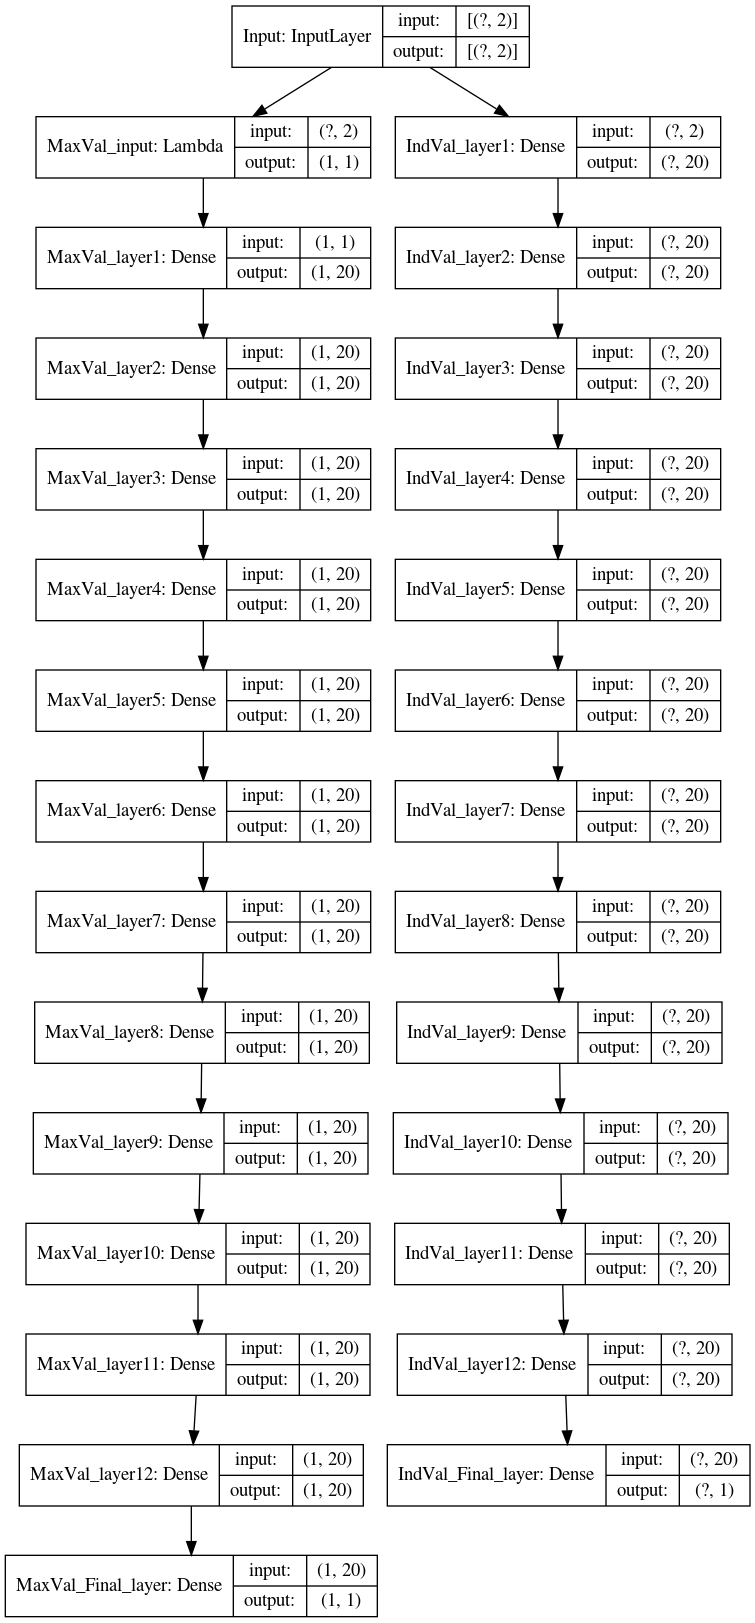

In [255]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)
# print(model.summary())

In [0]:
SGD_NM = tf.keras.optimizers.SGD(learning_rate=0.003,
                                        momentum=0.1,
                                        nesterov=True)
model.compile(loss='mse', optimizer=SGD_NM, metrics=['mape'])


In [257]:
for i in range(int(X.shape[0]/201)):
    print(X[i*201])

[0. 7.]
[0. 9.]
[0. 5.]


In [0]:
early_stopping_callback = EarlyStopping(monitor='val_IndVal_Final_layer_mape', 
                                        patience=500,
                                        min_delta= 1e-3,
                                        restore_best_weights=True,
                                        mode='auto',
                                        verbose=True)


class PredCallback(Callback):
    def __init__(self, pred_data):
        self.pred_data = pred_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch%10==0:
            X_pred, y_pred = self.pred_data
            prediction = model.predict(X_pred)
            pred = prediction[0]*prediction[1]
            for i in range(int(X_pred.shape[0]/201)):
                max_val = get_max_APE(get_APE(pred[i*201:(i+1)*201],y_pred[i*201:(i+1)*201]))
                print("For epoch = %d and L/D = %.1f, the MAPE is %f at x: %f" %(epoch,
                                                                                X_pred[i*201,1],
                                                                                max_val[0],
                                                                                max_val[1]))

In [0]:
##### Using sklearn to split the data into train and test sets with shuffling ####
X_train, X_test, y_train_comb, y_test_comb = train_test_split(X, y_comb, test_size=0.2, random_state=42, shuffle=True)


y_norm_train = y_train_comb[:,0]
y_max_train = y_train_comb[:,1]
y_norm_test = y_test_comb[:,0]
y_max_test = y_test_comb[:,1]

In [260]:
history = model.fit(X_train,
                    [y_train_comb[:,0],y_train_comb[:,1]],
                    batch_size = 2,
                    epochs=20000,
                    verbose=False,
                    validation_data=(X_test, [y_test_comb[:,0],y_test_comb[:,1]]),
                    callbacks=[early_stopping_callback, PredCallback((X_pred,y_pred))])

model.save('temp_models/SiameseModel')

Streaming output truncated to the last 5000 lines.
For epoch = 7430 and L/D = 3.0, the MAPE is 48.946682 at x: 68.000000
For epoch = 7430 and L/D = 9.0, the MAPE is 0.160111 at x: 96.000000
For epoch = 7440 and L/D = 6.0, the MAPE is 0.045469 at x: 146.000000
For epoch = 7440 and L/D = 6.5, the MAPE is 0.099647 at x: 156.000000
For epoch = 7440 and L/D = 7.5, the MAPE is 0.128366 at x: 164.000000
For epoch = 7440 and L/D = 8.0, the MAPE is 0.133476 at x: 170.000000
For epoch = 7440 and L/D = 8.5, the MAPE is 0.137189 at x: 167.000000
For epoch = 7440 and L/D = 10.0, the MAPE is 0.247327 at x: 30.000000
For epoch = 7440 and L/D = 5.0, the MAPE is 0.392768 at x: 46.000000
For epoch = 7440 and L/D = 4.0, the MAPE is 22.107213 at x: 31.000000
For epoch = 7440 and L/D = 4.5, the MAPE is 1.966977 at x: 30.000000
For epoch = 7440 and L/D = 3.0, the MAPE is 48.468445 at x: 68.000000
For epoch = 7440 and L/D = 9.0, the MAPE is 0.165840 at x: 37.000000
For epoch = 7450 and L/D = 6.0, the MAPE is

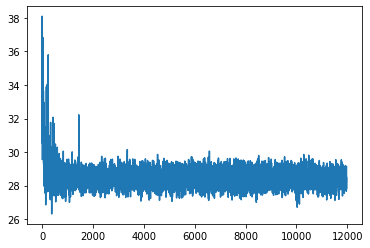

In [261]:
plt.plot(history.history['val_MaxVal_Final_layer_mape'])

In [262]:
print(history.history.keys())

dict_keys(['loss', 'IndVal_Final_layer_loss', 'MaxVal_Final_layer_loss', 'IndVal_Final_layer_mape', 'MaxVal_Final_layer_mape', 'val_loss', 'val_IndVal_Final_layer_loss', 'val_MaxVal_Final_layer_loss', 'val_IndVal_Final_layer_mape', 'val_MaxVal_Final_layer_mape'])


In [0]:
for i in range(int(pred[1].shape[0]/201)):
    print(X_pred_max[i*201])

In [0]:
for i in range(int(pred[1].shape[0]/201)):
    
    print(abs(pred[1][i*201]-y_pred_max[i*201])/y_pred_max[i*201])

<Figure size 432x288 with 0 Axes>

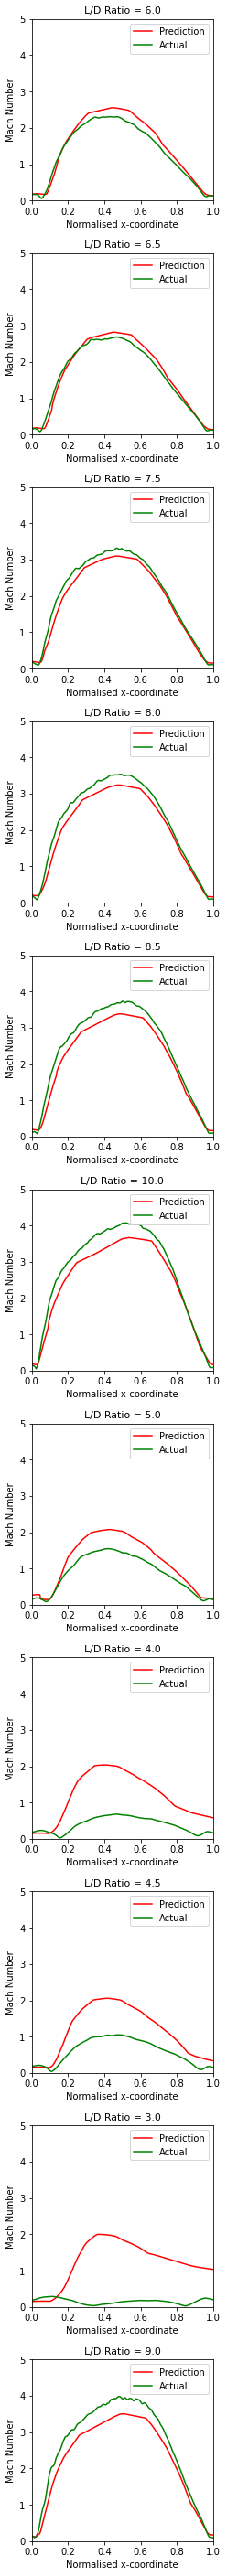

In [265]:
nrows=int(X_pred.shape[0]/201)
fig3 = plt.figure()
fig, axes = plt.subplots(nrows)
fig.set_size_inches(6,39)
for j in range(nrows):
    axes[j].plot(X_n_pred[:201],
                  pred[j*201:(j+1)*201],
                  'r',
                  label='Prediction')
    axes[j].plot(X_n_pred[j*201:(j+1)*201], y_pred[j*201:(j+1)*201], 'g', label='Actual')
    axes[j].set(xlabel="Normalised x-coordinate", ylabel="Mach Number")
    axes[j].set_title('L/D Ratio = %.1f' %(X_pred_max[201*j]), fontsize=11)
    axes[j].legend(loc="upper right")
    axes[j].set_xlim((0,1))
    axes[j].set_ylim((0,5))
    axes[j].set_aspect(0.2)

fig = plt.gcf()
plt.tight_layout(pad=0.25, h_pad=1.25, w_pad=0.25, rect=None)
# plt.savefig(save_post_dir + 'cumilative_ind_%s_predictions.png' %(opti_name), dpi=500)
plt.show(fig3)
plt.close(fig3)

In [0]:
# for i in range(int(X_pred.shape[0]/201)):
#   print("For L/D = %.1f, the MAPE is %f" %(X_pred[i*201, 1], get_max_APE(
#         get_APE(pred[i*201:(i+1)*201], y_pred[i*201:(i+1)*201]))))

In [267]:
prediction = model.predict(X_pred)
pred = prediction[0]*prediction[1]
for i in range(int(X_pred.shape[0]/201)):
    max_val = get_max_APE(get_APE(pred[i*201:(i+1)*201],y_pred[i*201:(i+1)*201]))
    print("For L/D = %.1f, the MAPE is %f at x: %f" %(X_pred[i*201,1],
                                                      max_val[0],
                                                      max_val[1]))

For L/D = 6.0, the MAPE is 0.246969 at x: 162.000000
For L/D = 6.5, the MAPE is 0.134708 at x: 156.000000
For L/D = 7.5, the MAPE is 0.105186 at x: 164.000000
For L/D = 8.0, the MAPE is 0.111924 at x: 170.000000
For L/D = 8.5, the MAPE is 0.112759 at x: 167.000000
For L/D = 10.0, the MAPE is 0.235952 at x: 30.000000
For L/D = 5.0, the MAPE is 0.497452 at x: 46.000000
For L/D = 4.0, the MAPE is 23.631312 at x: 31.000000
For L/D = 4.5, the MAPE is 2.180355 at x: 30.000000
For L/D = 3.0, the MAPE is 52.375095 at x: 68.000000
For L/D = 9.0, the MAPE is 0.149987 at x: 37.000000


In [268]:
prediction = model.predict(X_pred)
print(prediction)

[array([[0.08592229],
       [0.08564849],
       [0.08550851],
       ...,
       [0.02452652],
       [0.0199493 ],
       [0.01537107]], dtype=float32), array([[2.78418 ],
       [2.78418 ],
       [2.78418 ],
       ...,
       [3.436482],
       [3.436482],
       [3.436482]], dtype=float32)]


In [269]:
MiniModel

NameError: ignored